In [39]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
#for image transform
import cv2

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200


from model_loader_CP import *


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

%load_ext autoreload
%autoreload 2
%load_ext autotime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.23 s


In [2]:
import time

## keep the GPU going
rand_tensor = torch.rand((2, 5)).cuda()
while True:
    rand_tensor = rand_tensor + (torch.rand((2, 5))*0.00000000001).cuda()
    time.sleep(35)



AssertionError: 
The NVIDIA driver on your system is too old (found version 10010).
Please update your GPU driver by downloading and installing a new
version from the URL: http://www.nvidia.com/Download/index.aspx
Alternatively, go to: https://pytorch.org to install
a PyTorch version that has been compiled with your version
of the CUDA driver.

time: 152 ms


In [7]:
print(torch.__version__)

1.5.0
time: 2.64 ms


In [7]:
import sys
print (sys.version_info)

sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
time: 1.59 ms


In [4]:
!which python


/home/cp2530/.conda/envs/deeplearning/bin/python
time: 141 ms


In [8]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

time: 199 ms


In [9]:
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

time: 983 µs


In [10]:
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

time: 1.29 ms


In [11]:
#get sample
transform = torchvision.transforms.ToTensor()

unlabeled_trainset = UnlabeledDataset(image_folder=image_folder,scene_index=unlabeled_scene_index, first_dim='sample', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=3, shuffle=True, num_workers=2)

time: 1.95 ms


In [12]:
# [batch_size, 6(images per sample), 3, H, W]
sample = iter(trainloader).next()
print(sample.shape)

torch.Size([3, 6, 3, 256, 306])
time: 1.63 s


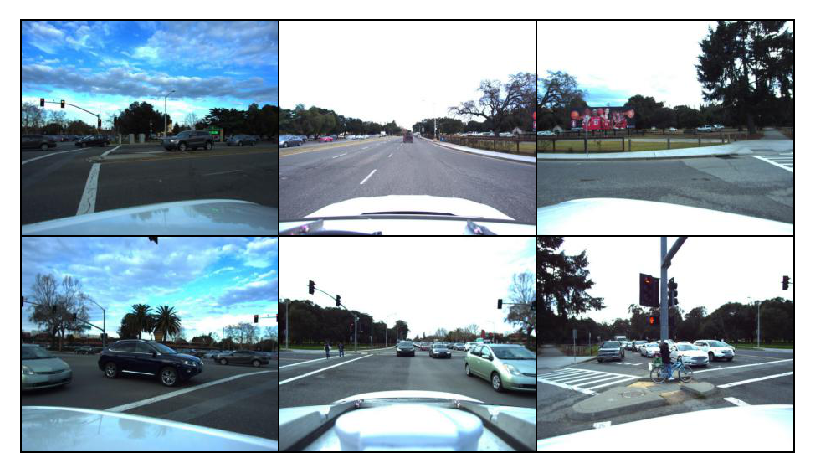

time: 1.07 s


In [13]:
#The 6 images orgenized in the following order:
# CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
plt.imshow(torchvision.utils.make_grid(sample[2], nrow=3).numpy().transpose(1, 2, 0)) #need the transpose
plt.axis('off');

In [14]:
# get individual image
unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=unlabeled_scene_index, first_dim='image',transform=transform) #change first_dim to 'image'
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=1, shuffle=True, num_workers=2) #change batchsize to 2

time: 1.51 ms


torch.Size([1, 3, 256, 306])
tensor(2)


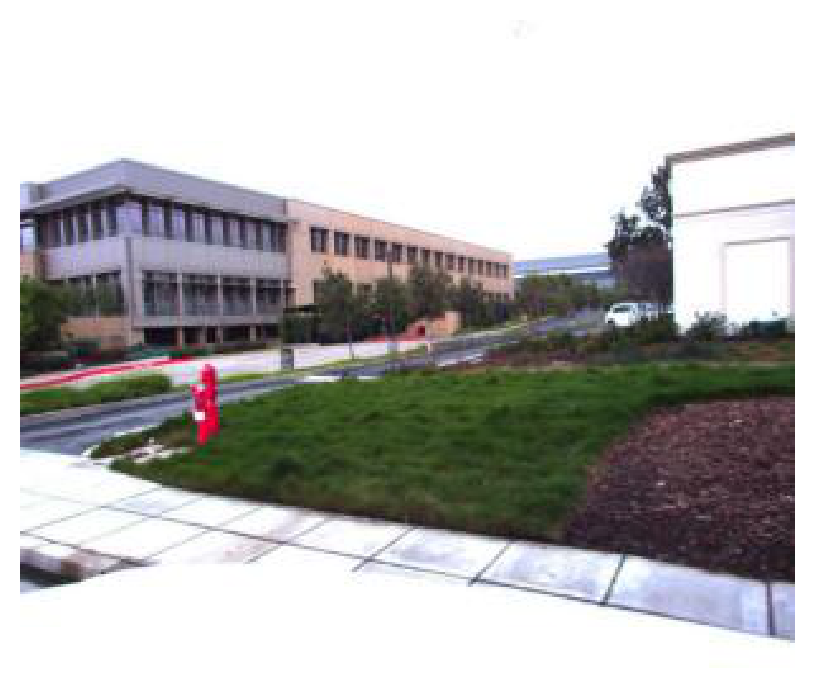

time: 265 ms


In [15]:
# [batch_size, 3 (channels, H, W]
trainloader_iter = iter(trainloader)
for i in range(6):
    image, camera_index = trainloader_iter.next()
    print(image.shape)
    print(camera_index[0])
    plt.imshow(image[0].numpy().transpose(1, 2, 0))
    plt.axis('off');
    break

In [16]:
image.min() #all image values are between 0 and 1

tensor(0.)

time: 4.03 ms


In [17]:
image.size

<function Tensor.size>

time: 2.6 ms


In [18]:
# Camera_index is to tell you which camera is used. The order is 5
# 0 : CAM_FRONT_LEFT, 1: CAM_FRONT, 2: CAM_FRONT_RIGHT, 3: CAM_BACK_LEFT, 4: CAM_BACK, 5: CAM_BACK_RIGHT
print(camera_index[0])

tensor(2)
time: 349 ms


In [19]:
### Labeled Dataset ###
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder, annotation_file=annotation_csv,
scene_index=labeled_scene_index,
transform=transform,
extra_info=True
)

time: 239 ms


In [20]:
LB_trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2,shuffle=True, num_workers=2, collate_fn=collate_fn)

time: 738 µs


In [21]:
sample, target, road_image, extra = iter(LB_trainloader).next()
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 306])
time: 776 ms


In [22]:
len(sample) #sample is the size of the batch size

2

time: 2.65 ms


In [23]:
sample[0].shape

torch.Size([6, 3, 256, 306])

time: 14.7 ms


(-0.5, 305.5, 255.5, -0.5)

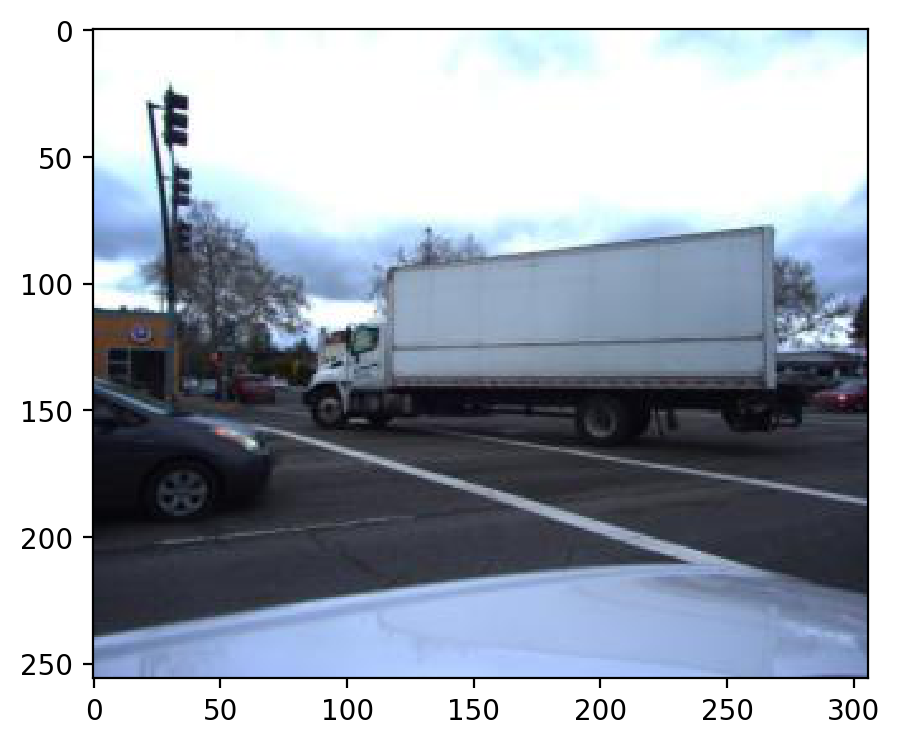

time: 591 ms


In [24]:
plt.imshow(sample[0][0].numpy().transpose(1, 2, 0)) #one image in the labled set
plt.axis('on')

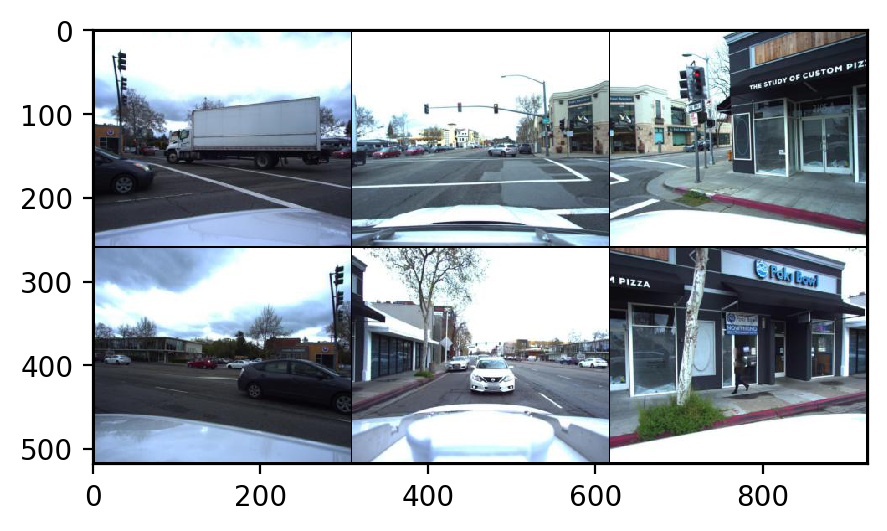

time: 440 ms


In [25]:
plt.imshow(torchvision.utils.make_grid(sample[0], nrow=3).numpy().transpose(1, 2, 0)) #need the transpose
plt.axis('on');

In [26]:
#bounding boxes

# The shape of bounding box is [batch_size, N (the number of object), 2, 4]
print(target[0]['bounding_box'].shape)


torch.Size([16, 2, 4])
time: 1.28 ms


In [27]:
# All bounding box are retangles
# Each bounding box is organized with four corners of the box
# All the values are in meter and bounded by 40 meters, and the origin is the center of ego car
# the order of the four courners are front left, front right, back left and back right
print(target[0]['bounding_box'][0])

tensor([[-17.4599, -17.4110, -21.9772, -21.9283],
        [ -1.5452,  -3.3309,  -1.6688,  -3.4545]], dtype=torch.float64)
time: 46.5 ms


In [28]:
# Each bounding box has a category
# 'other_vehicle': 0,
# 'bicycle': 1,
# 'car': 2,
# 'pedestrian': 3,
# 'truck': 4,
# 'bus': 5,
# 'motorcycle': 6,
# 'emergency_vehicle': 7,
# 'animal': 8
print(target[0]['category'])

tensor([2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 4, 2, 2, 2])
time: 1.51 ms


tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


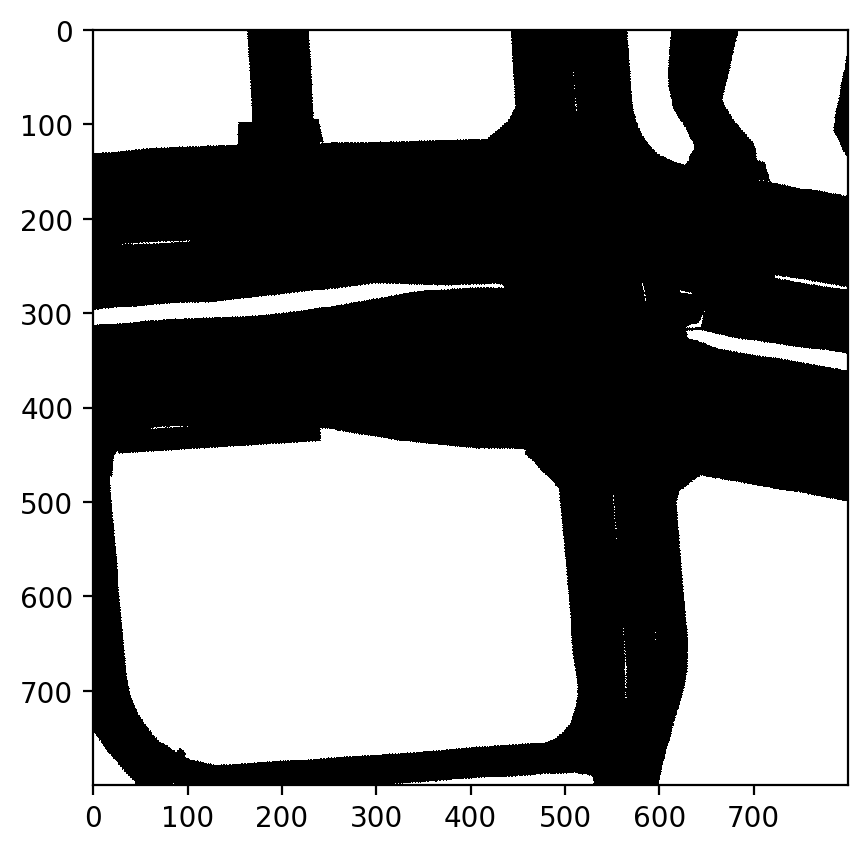

time: 277 ms


In [29]:
#roadmap layout
# The road map layout is encoded into a binary array of size [800, 800] per sample
# Each pixel is 0.1 meter in physiscal space, so 800 * 800 is 80m * 80m centered at the ego car
# The ego car is located in the center of the map (400, 400) and it is always facing the left
fig, ax = plt.subplots()
ax.imshow(road_image[0], cmap='binary');
print(road_image[0])




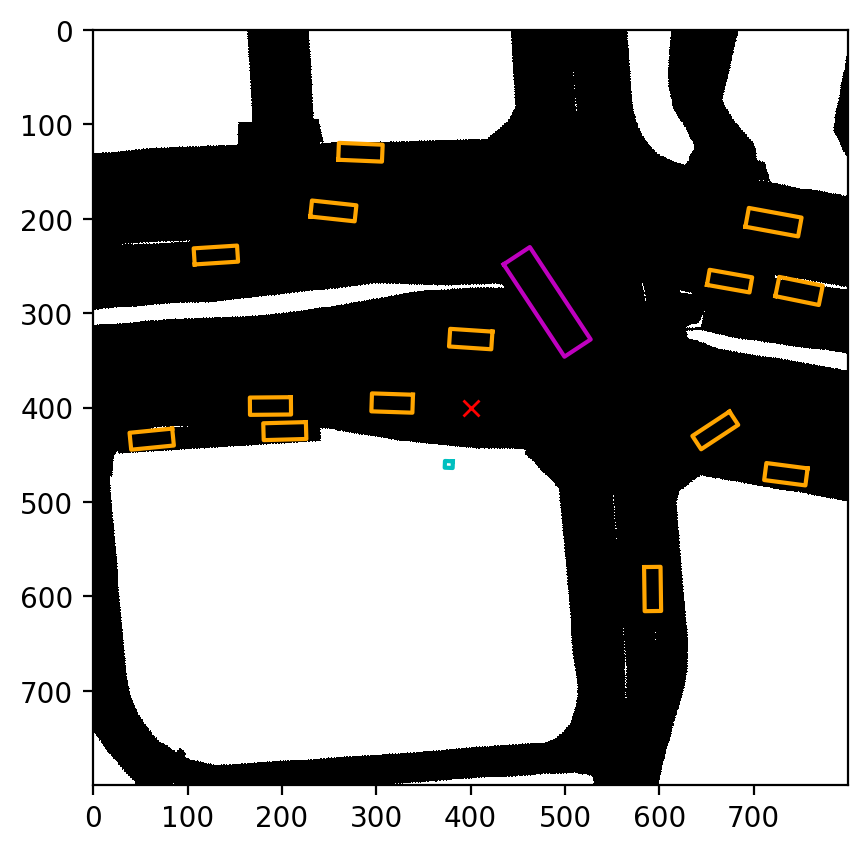

time: 331 ms


In [30]:
##visualize bounding boxes
fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(target[0]['bounding_box']):
# You can check the implementation of the draw box to understand howit works
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])

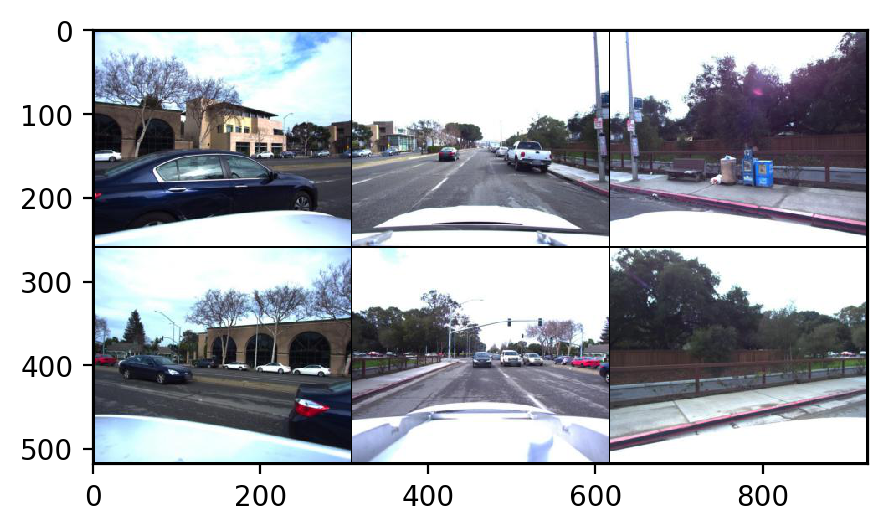

time: 420 ms


In [31]:
### self exploration ###
plt.imshow(torchvision.utils.make_grid(sample[1], nrow=3).numpy().transpose(1, 2, 0)) #need the transpose
plt.axis('on');

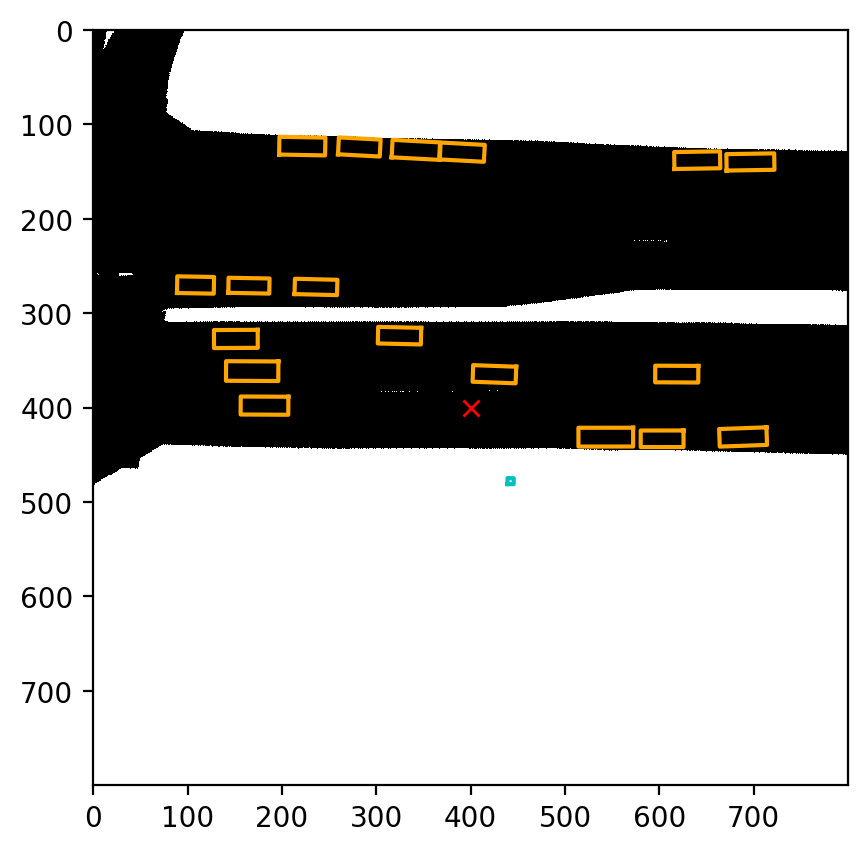

time: 392 ms


In [32]:
fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
ax.imshow(road_image[1], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(target[1]['bounding_box']):
# You can check the implementation of the draw box to understand howit works
    draw_box(ax, bb, color=color_list[target[1]['category'][i]])

(-0.5, 305.5, 255.5, -0.5)

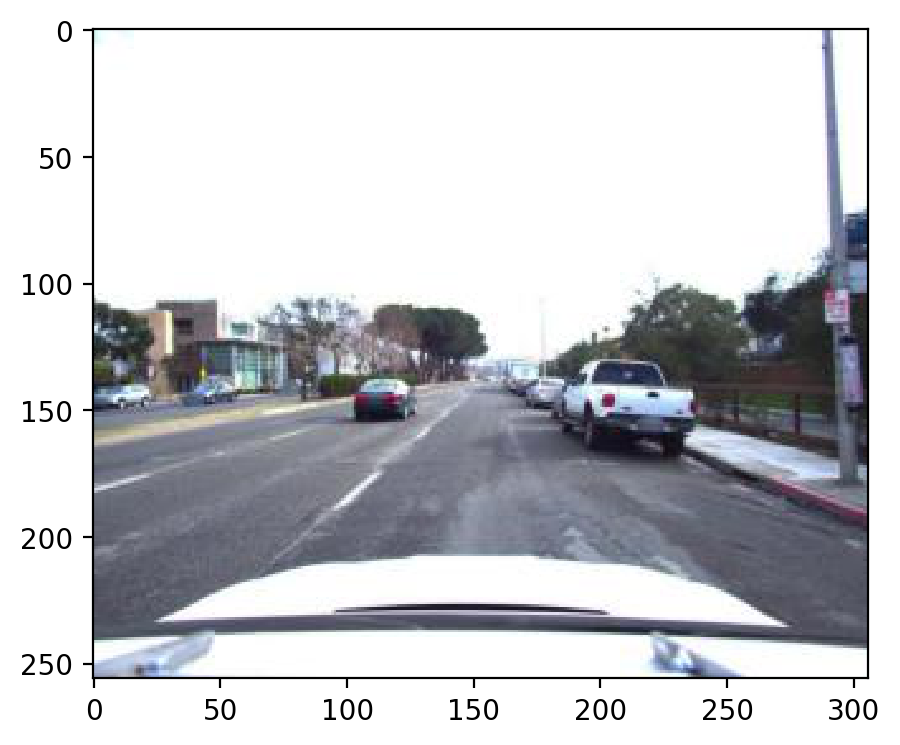

time: 295 ms


In [33]:
plt.imshow(sample[1][1].numpy().transpose(1, 2, 0)) #one image in the labled set
plt.axis('on')

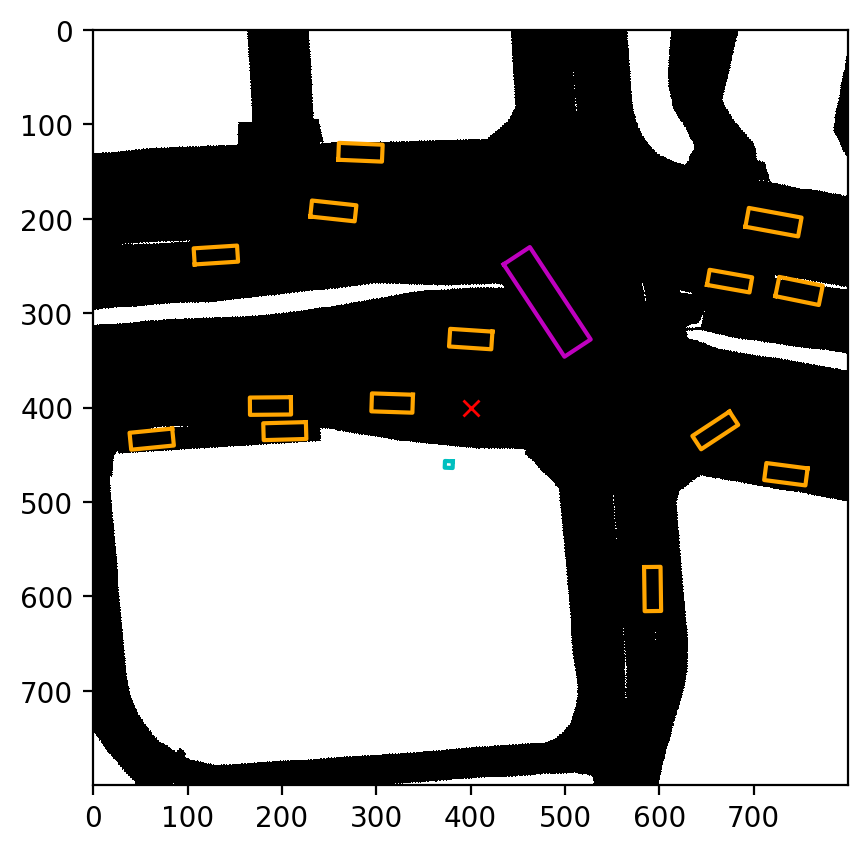

time: 344 ms


In [34]:
fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(target[0]['bounding_box']):
# You can check the implementation of the draw box to understand howit works
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])

In [35]:
# img = sample[1][1].numpy().transpose(1, 2, 0)
# img = img[124:,:]
# plt.imshow(img) #one image in the labled set
# plt.axis('on')

time: 875 µs


In [36]:
img = sample[1][1].numpy().transpose(1, 2, 0)

time: 1.46 ms


In [37]:
type(img)

numpy.ndarray

time: 2.77 ms


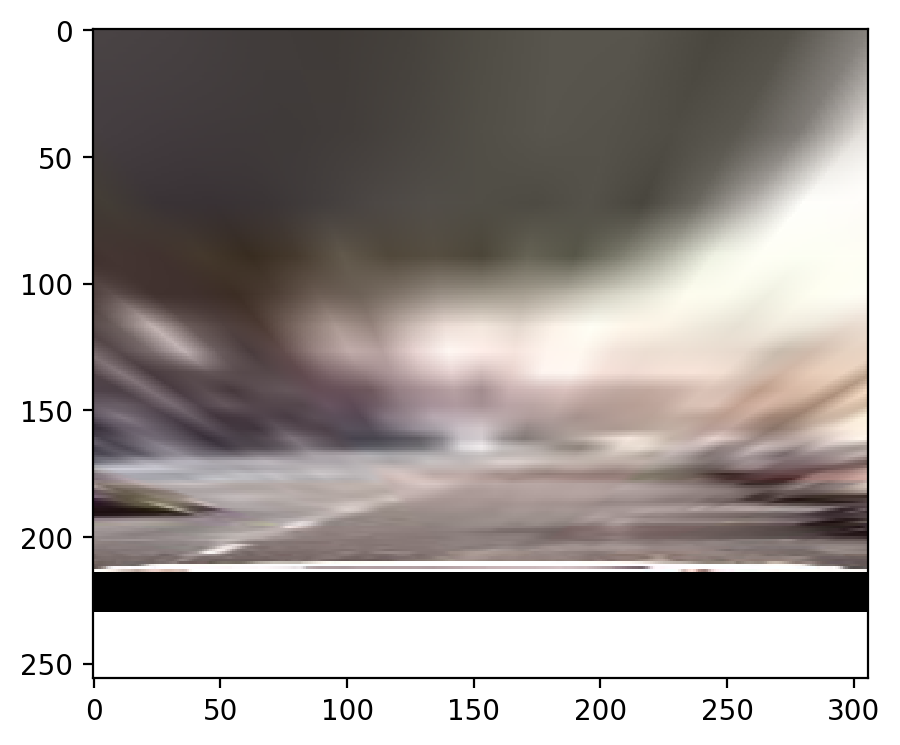

time: 447 ms


In [40]:
# attempt to rotage image

IMAGE_H = 256
IMAGE_W = 306

#src = np.float32([[0, IMAGE_H], [IMAGE_W, IMAGE_H], [0, 0], [IMAGE_W, 0]])
#dst = np.float32([[100, IMAGE_H], [200, IMAGE_H], [0, 0], [IMAGE_W, 0]]) #trail and error

#order is upleft, up right, lower right, lower left, clockwise
src = np.float32([[145, 125], [155, 125], [250, 210], [50, 210]])
dst = np.float32([[0, 0], [306, 0], [306, 210], [0, 210]])

M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
warped_img = cv2.warpPerspective(img, M, (IMAGE_W, IMAGE_H)) # Image warping
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB)) # Show results
plt.show()


In [41]:
img.shape

(256, 306, 3)

time: 2.83 ms


In [42]:
# import time

# ## keep the GPU going
# rand_tensor = torch.rand((2, 5)).cuda()
# while True:
#     rand_tensor = rand_tensor + (torch.rand((2, 5))*0.00000000001).cuda()
#     time.sleep(15)
    

time: 739 µs


In [43]:
306*2

612

time: 2.29 ms


In [44]:
batch_size = 10
sample_rand = torch.rand((batch_size, 6, 3, 256, 306))

time: 140 ms


In [45]:
sample_rand.shape

torch.Size([10, 6, 3, 256, 306])

time: 2.72 ms


In [46]:
torch.stack([sample_rand, sample_rand], 0).shape

torch.Size([2, 10, 6, 3, 256, 306])

time: 55.7 ms


In [47]:
##get a new sample
sample, target, road_image, extra = iter(LB_trainloader).next()
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 306])
time: 734 ms


In [48]:
transTot = transforms.Compose([transforms.ToPILImage(),transforms.Resize((880, 880)), transforms.ToTensor()])
    

#transtoImg = 
#transResize = torchvision.
#transtoTensor = 


time: 738 µs


In [50]:
sing_samp = sample[0]
sing_samp[0][1].shape

torch.Size([256, 306])

time: 3.26 ms


In [51]:
sing_samp[0][1].max()

tensor(1.)

time: 3.73 ms


In [52]:
#sR_1ch = sample_rand.sum(dim = 2) #sum across 3 channels
#print(sR_1ch.shape)
bstack_list = []


for i in range(len(sample)): #for each of the 2 in the batch
    print(i)
    sing_samp = sample[i] #get each sample
    A1 = sing_samp[0][0]
    A2 = sing_samp[0][1]
    A3 = sing_samp[0][2]
    
    B1 = sing_samp[1][0]
    B2 = sing_samp[1][1]
    B3 = sing_samp[1][2]
    
    C1 = sing_samp[2][0]
    C2 = sing_samp[2][1]
    C3 = sing_samp[2][1]
    
    
    D1 = sing_samp[3][0]
    D2 = sing_samp[3][1]
    D3 = sing_samp[3][2]
    
    E1 = sing_samp[4][0]
    E2 = sing_samp[4][1]
    E3 = sing_samp[4][2]
    
    F1 = sing_samp[5][0]
    F2 = sing_samp[5][1]
    F3 = sing_samp[5][2]
    
    print("F shape {}".format(F1.shape))
    
    T1 = torch.cat([A1, B1, C1], 0)
    T2 = torch.cat([A2, B2, C2], 0)
    T3 = torch.cat([A3, B3, C3], 0)
    
    B1 = torch.cat([D1, E1, F1], 0)
    B2 = torch.cat([D2, E2, F2], 0)
    B3 = torch.cat([D3, E3, F3], 0)
    print("T1 shape {}".format(T1.shape))
    
    comb1 = torch.cat([T1,B1], 1)
    comb2 = torch.cat([T2,B2], 1)
    comb3 = torch.cat([T3,B3], 1)
    
    print("comb1 shape {}".format(comb1.shape)) #should be 768, 612
    comb = torch.stack([comb1, comb2, comb3])
    print("stacked comb {}".format(comb.shape))
    comb =transTot(comb)
    comb = comb.sum(0) #sum across all 3
    print(comb.shape) 
        
    print(comb.size)
    bstack_list.append(comb)
result = torch.stack(bstack_list, 0)
print(result.shape) #should be (2, 800, 800)


0
F shape torch.Size([256, 306])
T1 shape torch.Size([768, 306])
comb1 shape torch.Size([768, 612])
stacked comb torch.Size([3, 768, 612])
torch.Size([880, 880])
<built-in method size of Tensor object at 0x2b474d35b2d0>
1
F shape torch.Size([256, 306])
T1 shape torch.Size([768, 306])
comb1 shape torch.Size([768, 612])
stacked comb torch.Size([3, 768, 612])
torch.Size([880, 880])
<built-in method size of Tensor object at 0x2b476d459f78>
torch.Size([2, 880, 880])
time: 102 ms


In [53]:
sample, target, road_image, extra = iter(LB_trainloader).next()

time: 762 ms


In [55]:
road_image[0].shape

torch.Size([800, 800])

time: 3.21 ms


In [56]:
 
##get a new sample

print(torch.stack(sample).shape)
result = ModelLoader.get_binary_road_map(sample)
print(result.shape)

torch.Size([2, 6, 3, 256, 306])
torch.Size([2, 880, 880])
time: 99 ms


In [57]:
result.cuda()

AssertionError: 
The NVIDIA driver on your system is too old (found version 10010).
Please update your GPU driver by downloading and installing a new
version from the URL: http://www.nvidia.com/Download/index.aspx
Alternatively, go to: https://pytorch.org to install
a PyTorch version that has been compiled with your version
of the CUDA driver.

time: 12.3 ms


In [60]:
!conda list cudatoolkit

# packages in environment at /home/cp2530/.conda/envs/deeplearning:
#
# Name                    Version                   Build  Channel
cudatoolkit               10.2.89         hfd86e86_0.conda
time: 1.47 s


In [ ]:
#try BCE loss

In [ ]:
(800-612)/2

In [ ]:
! pwd

In [ ]:
image_path = "./data/scene_0/sample_0/CAM_BACK_LEFT.jpeg"
image = Image.open(image_path)

In [ ]:
image.size

In [ ]:

sample_rand_b1 = sample_rand[0]
sample_rand_b1 = sample_rand_by.sum()